# LSI and LDA for search

## The standard IR system as baseline

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo
from twitter import TwitterDataset, ENTITY, DOMAIN
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from string import punctuation

In [3]:
db = pymongo.MongoClient()['twitter']['tweets']
tdata = TwitterDataset(db)

In [4]:
estats = tdata.entity_queries_stats
dstats = tdata.domain_queries_stats

In [5]:
stopw = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in punctuation and word not in stopw and not word.startswith('http')] 

### Naive search engine

In [6]:
from search import TfIdfSearchEngine

In [7]:
E = TfIdfSearchEngine(tdata.search_base, tokenize)

In [94]:
query = 'TV Shows'
query_text = 'TV shows'
ground_truth = tdata.ground_truth(query, query_type=DOMAIN)
ranking = E.search(query_text)

In [95]:
tp, fp, fn, tn = TfIdfSearchEngine.feedback(ranking, 
                                            ground_truth, top_k=4500)

In [96]:
print(len(tp), len(fp), len(fn), len(tn))
print('precision', len(tp) / (len(tp) + len(fp)))
print('recall', len(tp) / (len(tp) + len(fn)))

414 4086 1628 16222
precision 0.092
recall 0.20274240940254654


In [97]:
ranking_map = dict([(tweet_id, score) for _, tweet_id, score in ranking])
document_ids = [x for x, y in tdata.search_base]
y_true = [1 if x in ground_truth else 0 for x in document_ids]
scores = [ranking_map[x] if x in ranking_map.keys() else 0 for x in document_ids]
y_pred = [1 if ranking_map[x] > 0 else 0 for x in document_ids]

## Evaluate

In [98]:
import matplotlib.pyplot as plt

In [99]:
import sklearn.metrics as mt

In [100]:
precision, recall, thresholds = mt.precision_recall_curve(y_true, scores)
intp = [max(precision[:i+1]) for i in range(len(precision))]

In [101]:
cm = mt.confusion_matrix(y_true, y_pred)
cmd = mt.ConfusionMatrixDisplay(confusion_matrix=cm)

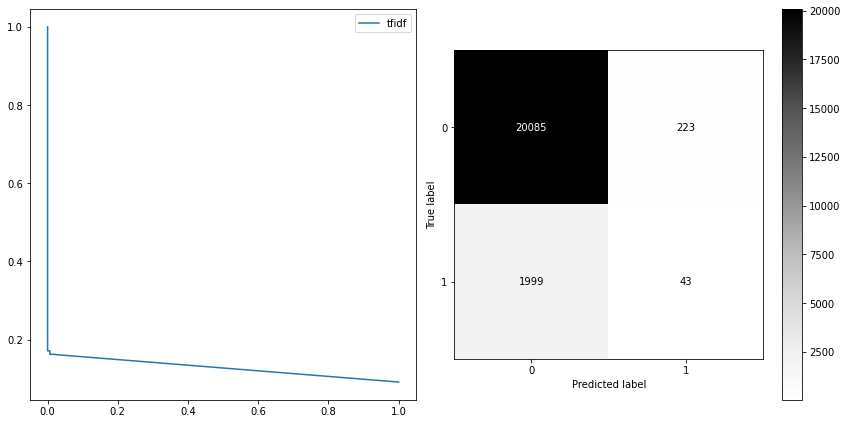

In [102]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].plot(recall, intp, label='tfidf')
cmd.plot(ax=ax[1], values_format='d', cmap='Greys')
ax[0].legend()
plt.tight_layout()
plt.show()

## Prepare for gensim

In [103]:
from gensim.corpora.textcorpus import TextCorpus
from gensim.corpora import Dictionary

In [104]:
class TweetsCorpus(object):
    def __init__(self, documents):
        self.documents = documents
    def get_texts(self):
        for doc in self.documents:
            yield [word for word in tokenize(doc)]
    def __len__(self):
        return sum(1 for _ in self.get_texts())

In [105]:
tweets_corpus = TweetsCorpus([y for x, y in tdata.search_base])

In [106]:
dictionary = Dictionary(tweets_corpus.get_texts())
corpus = [dictionary.doc2bow(text) for text in tweets_corpus.get_texts()]

## LSI

In [158]:
from gensim.models import LsiModel

In [159]:
dstats.shape[0]

53

In [160]:
model = LsiModel(corpus, id2word=dictionary, num_topics=20)

In [161]:
vectorized_corpus = model[corpus]

In [162]:
print(len(vectorized_corpus[0]))
print(vectorized_corpus[0][:2])

4
[(1, 0.117424354), (3, 0.5254149)]


### Query to vector

In [163]:
print(query_text)
print(tokenize(query_text))
print(dictionary.doc2bow(tokenize(query_text)))
word_vector = model[dictionary.doc2bow(tokenize(query_text))]
main_topics = sorted(word_vector, key=lambda x: -np.abs(x[1]))[:2]
print(main_topics)

TV shows
['tv', 'shows']
[(213, 1), (2719, 1)]
[(11, 0.68332136), (14, 0.016667299)]


In [164]:
model.print_topic(11)

'0.017*"killed" + 0.016*"baby" + 0.014*"breaks" + 0.012*"woman" + 0.011*"car" + 0.011*"’" + 0.011*"silence" + 0.010*"police" + 0.009*"wife" + 0.009*"left"'

In [165]:
q_vector = model[dictionary.doc2bow(tokenize(query_text))]

In [166]:
q_vector[:2]

[(0, 0.0166673), (1, 0.0166673)]

In [167]:
LSI = np.zeros((len(vectorized_corpus), model.num_topics))
for i, vector in enumerate(vectorized_corpus):
    for topic_id, score in vector:
        LSI[i, topic_id] = score

In [168]:
LSI.shape

(22350, 20)

In [169]:
Q = np.array([y for x, y in q_vector]).reshape(1, -1)

### Match

In [170]:
from sklearn.metrics.pairwise import cosine_similarity

In [171]:
S = cosine_similarity(Q, LSI)

In [172]:
lsi_scores = S[0]
lsi_pred = [1 if x > 0 else 0 for x in lsi_scores]

In [173]:
lsi_precision, lsi_recall, lsi_thresholds = mt.precision_recall_curve(y_true, lsi_scores)
lsi_intp = [max(lsi_precision[:i+1]) for i in range(len(lsi_precision))]

In [174]:
lsi_cm = mt.confusion_matrix(y_true, lsi_pred)
lsi_cmd = mt.ConfusionMatrixDisplay(confusion_matrix=lsi_cm)

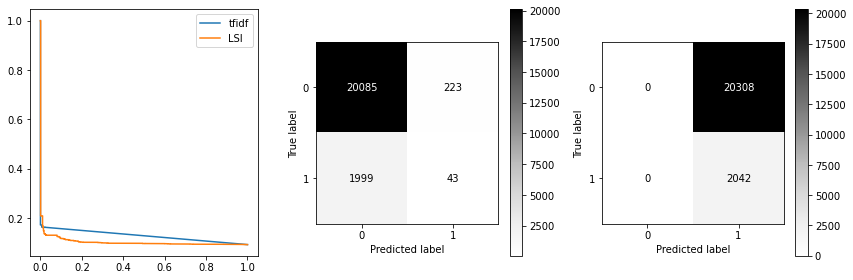

In [175]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(recall, intp, label='tfidf')
ax[0].plot(lsi_recall, lsi_intp, label='LSI')
cmd.plot(ax=ax[1], values_format='d', cmap='Greys')
lsi_cmd.plot(ax=ax[2], values_format='d', cmap='Greys')
ax[0].legend()
plt.tight_layout()
plt.show()

## Exercize
- Discuss the different nature of errors from FN to FP
- Try with a domain generic query like `TV Shows`